In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2007",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_06-Nov-2007.tar
Extracting /home/khoidh/data/VOCtrainval_06-Nov-2007.tar to /home/khoidh/data
#Training Samples: 209
#Validation Samples: 422
#Testing Samples: 213
#Training Batch: 7
#Validation Batch: 14
#Testing Batch: 7


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0,  5, 15, 21])


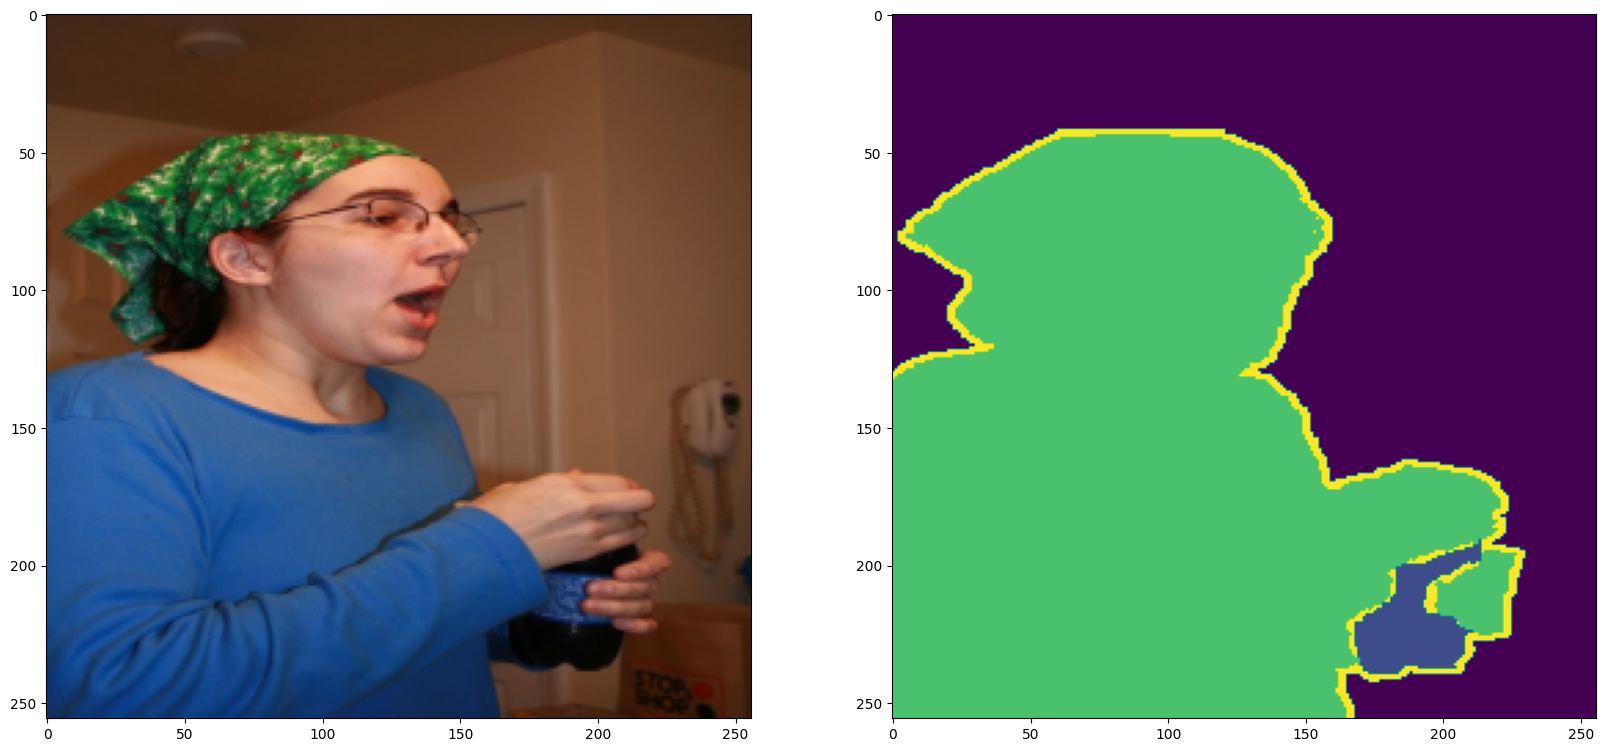

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.63it/s]


Epoch: 0 - TrainLoss: 3.8525289808000838 - ValidLoss: 7.421070575714111


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch: 1 - TrainLoss: 3.5553228173937117 - ValidLoss: 6.9740095138549805


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.17it/s]


Epoch: 2 - TrainLoss: 3.3621418135506764 - ValidLoss: 6.565404415130615


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch: 3 - TrainLoss: 3.2328576019832065 - ValidLoss: 6.260298252105713


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.44it/s]


Epoch: 4 - TrainLoss: 3.1124252591814314 - ValidLoss: 6.333726406097412


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch: 5 - TrainLoss: 2.9825914246695384 - ValidLoss: 5.988481044769287


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch: 6 - TrainLoss: 2.860464709145682 - ValidLoss: 5.6007184982299805


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch: 7 - TrainLoss: 2.7391646589551653 - ValidLoss: 5.394553184509277


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch: 8 - TrainLoss: 2.6084749358040944 - ValidLoss: 5.018485069274902


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Epoch: 9 - TrainLoss: 2.50664598601205 - ValidLoss: 4.841146469116211


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch: 10 - TrainLoss: 2.384807143892561 - ValidLoss: 4.373346328735352


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Epoch: 11 - TrainLoss: 2.3105267797197615 - ValidLoss: 4.678338050842285


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch: 12 - TrainLoss: 2.205063683646066 - ValidLoss: 4.198461055755615


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.38it/s]


Epoch: 13 - TrainLoss: 2.138582876750401 - ValidLoss: 4.013248920440674


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Epoch: 14 - TrainLoss: 2.067585434232439 - ValidLoss: 3.983829975128174


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.40it/s]


Epoch: 15 - TrainLoss: 2.0268042939049855 - ValidLoss: 4.537420272827148


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch: 16 - TrainLoss: 1.9656448193958826 - ValidLoss: 4.067385673522949


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.40it/s]


Epoch: 17 - TrainLoss: 1.8952539478029524 - ValidLoss: 3.653287410736084


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.37it/s]


Epoch: 18 - TrainLoss: 1.874284369604928 - ValidLoss: 4.090287685394287


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch: 19 - TrainLoss: 1.833269579069955 - ValidLoss: 3.883148670196533


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Epoch: 20 - TrainLoss: 1.7857678617749895 - ValidLoss: 3.375518798828125


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.22it/s]


Epoch: 21 - TrainLoss: 1.791255269731794 - ValidLoss: 4.061478137969971


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Epoch: 22 - TrainLoss: 1.7750720807484217 - ValidLoss: 4.048104286193848


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.24it/s]


Epoch: 23 - TrainLoss: 1.7289909635271346 - ValidLoss: 3.412842273712158


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch: 24 - TrainLoss: 1.722979290144784 - ValidLoss: 3.810673475265503


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch: 25 - TrainLoss: 1.6931217057364327 - ValidLoss: 3.6708269119262695


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch: 26 - TrainLoss: 1.662602424621582 - ValidLoss: 3.369645118713379


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.18it/s]


Epoch: 27 - TrainLoss: 1.6710664204188757 - ValidLoss: 3.5605921745300293


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch: 28 - TrainLoss: 1.6476226874760218 - ValidLoss: 3.1702513694763184


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Epoch: 29 - TrainLoss: 1.61365464755467 - ValidLoss: 2.7919747829437256


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.36it/s]


Epoch: 30 - TrainLoss: 1.6049984012331282 - ValidLoss: 2.964077949523926


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.37it/s]


Epoch: 31 - TrainLoss: 1.5910338163375854 - ValidLoss: 2.932156562805176


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch: 32 - TrainLoss: 1.5561745847974504 - ValidLoss: 2.801405668258667


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.13it/s]


Epoch: 33 - TrainLoss: 1.5653761114392961 - ValidLoss: 3.3997766971588135


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch: 34 - TrainLoss: 1.5442188126700265 - ValidLoss: 2.7145638465881348


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch: 35 - TrainLoss: 1.555155907358442 - ValidLoss: 3.321747303009033


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch: 36 - TrainLoss: 1.563980221748352 - ValidLoss: 3.685993194580078


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.40it/s]


Epoch: 37 - TrainLoss: 1.55318398135049 - ValidLoss: 3.8392515182495117


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch: 38 - TrainLoss: 1.5417992217200143 - ValidLoss: 2.8600239753723145


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch: 39 - TrainLoss: 1.5207385165350777 - ValidLoss: 3.2196264266967773


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch: 40 - TrainLoss: 1.5157715593065535 - ValidLoss: 3.3155055046081543


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch: 41 - TrainLoss: 1.4943606683186121 - ValidLoss: 2.8499183654785156


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.23it/s]


Epoch: 42 - TrainLoss: 1.4935093436922346 - ValidLoss: 3.2298262119293213


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch: 43 - TrainLoss: 1.5540590797151839 - ValidLoss: 4.603111267089844


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch: 44 - TrainLoss: 1.4587500095367432 - ValidLoss: 2.6413087844848633


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.19it/s]


Epoch: 45 - TrainLoss: 1.447169235774449 - ValidLoss: 2.4587056636810303


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Epoch: 46 - TrainLoss: 1.458392551967076 - ValidLoss: 3.075394868850708


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch: 47 - TrainLoss: 1.4713377101080758 - ValidLoss: 3.102811336517334


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]


Epoch: 48 - TrainLoss: 1.4206516913005285 - ValidLoss: 2.5996341705322266


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch: 49 - TrainLoss: 1.4449804850987025 - ValidLoss: 3.454512119293213


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Epoch: 50 - TrainLoss: 1.4033876657485962 - ValidLoss: 2.645728349685669


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch: 51 - TrainLoss: 1.3946573393685477 - ValidLoss: 2.8777341842651367


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch: 52 - TrainLoss: 1.4011508056095667 - ValidLoss: 3.0724034309387207


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.35it/s]


Epoch: 53 - TrainLoss: 1.3866046837397985 - ValidLoss: 2.9535703659057617


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.30it/s]


Epoch: 54 - TrainLoss: 1.4164110592433385 - ValidLoss: 3.5445258617401123


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch: 55 - TrainLoss: 1.3935109887804304 - ValidLoss: 3.0174999237060547


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch: 56 - TrainLoss: 1.3504715136119299 - ValidLoss: 2.5881667137145996


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Epoch: 57 - TrainLoss: 1.3420480830328805 - ValidLoss: 2.6490135192871094


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.34it/s]


Epoch: 58 - TrainLoss: 1.346528444971357 - ValidLoss: 2.9273383617401123


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch: 59 - TrainLoss: 1.3531024966921126 - ValidLoss: 3.2870094776153564


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch: 60 - TrainLoss: 1.3095995698656355 - ValidLoss: 2.631291151046753


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch: 61 - TrainLoss: 1.3108441489083427 - ValidLoss: 2.38264799118042


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch: 62 - TrainLoss: 1.3244158710752214 - ValidLoss: 3.4232287406921387


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.39it/s]


Epoch: 63 - TrainLoss: 1.3229275771549769 - ValidLoss: 2.852874755859375


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.46it/s]


Epoch: 64 - TrainLoss: 1.3015296799795968 - ValidLoss: 2.5502991676330566


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch: 65 - TrainLoss: 1.261455774307251 - ValidLoss: 2.6193323135375977


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s]


Epoch: 66 - TrainLoss: 1.2567024741853987 - ValidLoss: 2.956285238265991


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch: 67 - TrainLoss: 1.2678023406437464 - ValidLoss: 3.0969278812408447


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.28it/s]


Epoch: 68 - TrainLoss: 1.2218429361070906 - ValidLoss: 2.2149062156677246


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.22it/s]


Epoch: 69 - TrainLoss: 1.2186381305967058 - ValidLoss: 2.9160895347595215


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch: 70 - TrainLoss: 1.1835551772798811 - ValidLoss: 2.524742603302002


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch: 71 - TrainLoss: 1.2222283567701067 - ValidLoss: 2.9961581230163574


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.33it/s]


Epoch: 72 - TrainLoss: 1.193720476967948 - ValidLoss: 2.4223711490631104


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch: 73 - TrainLoss: 1.1592871972492762 - ValidLoss: 2.4371299743652344


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch: 74 - TrainLoss: 1.1432002782821655 - ValidLoss: 2.385495662689209


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.39it/s]


Epoch: 75 - TrainLoss: 1.1408474615642004 - ValidLoss: 2.485123634338379


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch: 76 - TrainLoss: 1.1539489371435983 - ValidLoss: 2.651796817779541


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.37it/s]


Epoch: 77 - TrainLoss: 1.1418159348624093 - ValidLoss: 2.719918727874756


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch: 78 - TrainLoss: 1.1214783361979894 - ValidLoss: 2.296718120574951


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch: 79 - TrainLoss: 1.1357420768056596 - ValidLoss: 1.9367774724960327


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.24it/s]


Epoch: 80 - TrainLoss: 1.1020172493798392 - ValidLoss: 2.108340263366699


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.22it/s]


Epoch: 81 - TrainLoss: 1.1321453366960799 - ValidLoss: 2.943816661834717


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch: 82 - TrainLoss: 1.089789969580514 - ValidLoss: 2.50219988822937


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch: 83 - TrainLoss: 1.0978181447301592 - ValidLoss: 2.6602277755737305


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch: 84 - TrainLoss: 1.0830043128558569 - ValidLoss: 2.500894069671631


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Epoch: 85 - TrainLoss: 1.0586358989988054 - ValidLoss: 2.0333456993103027


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch: 86 - TrainLoss: 1.0675163950238908 - ValidLoss: 1.8856583833694458


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch: 87 - TrainLoss: 1.1038013696670532 - ValidLoss: 2.8031468391418457


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.38it/s]


Epoch: 88 - TrainLoss: 1.0588422587939672 - ValidLoss: 2.093733310699463


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch: 89 - TrainLoss: 1.0402603234563554 - ValidLoss: 1.7543188333511353


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.31it/s]


Epoch: 90 - TrainLoss: 1.06275794335774 - ValidLoss: 2.7075088024139404


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch: 91 - TrainLoss: 1.065442408834185 - ValidLoss: 2.7033605575561523


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch: 92 - TrainLoss: 1.066578941685813 - ValidLoss: 2.1321630477905273


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch: 93 - TrainLoss: 1.0854772925376892 - ValidLoss: 3.1799960136413574


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch: 94 - TrainLoss: 1.055117394242968 - ValidLoss: 2.482801675796509


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch: 95 - TrainLoss: 1.0389426691191537 - ValidLoss: 2.015484094619751


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.23it/s]


Epoch: 96 - TrainLoss: 1.043119592326028 - ValidLoss: 2.1151061058044434


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.28it/s]


Epoch: 97 - TrainLoss: 1.0541537744658334 - ValidLoss: 2.165282964706421


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch: 98 - TrainLoss: 1.0274731261389596 - ValidLoss: 1.7844409942626953


100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.32it/s]

Epoch: 99 - TrainLoss: 1.043312907218933 - ValidLoss: 2.1647090911865234


<All keys matched successfully>

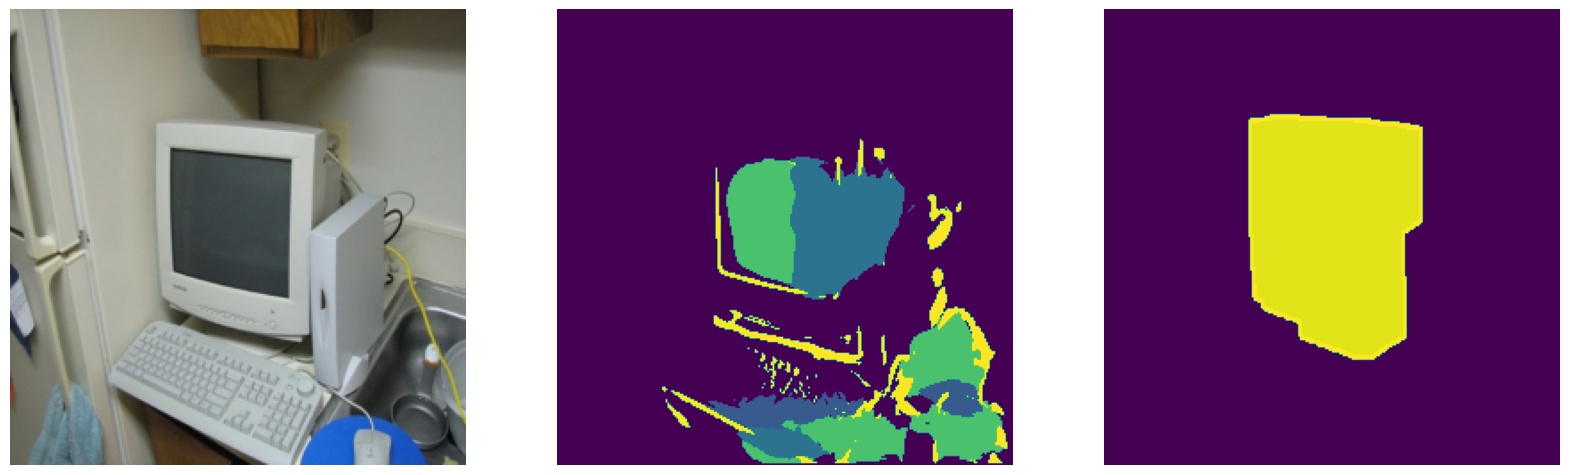

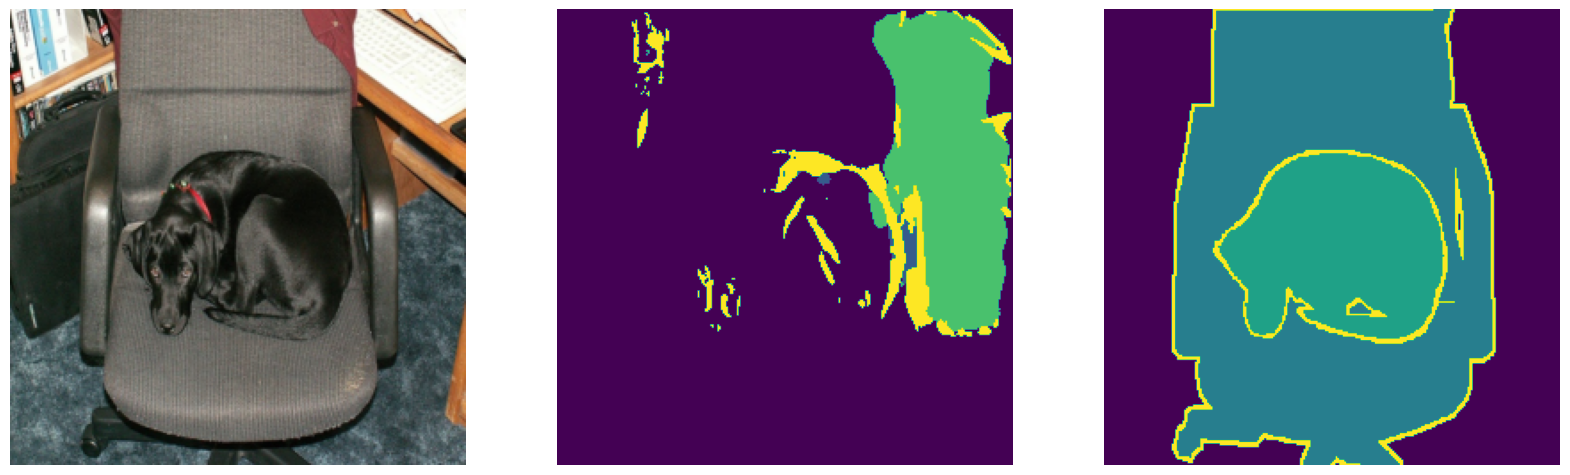

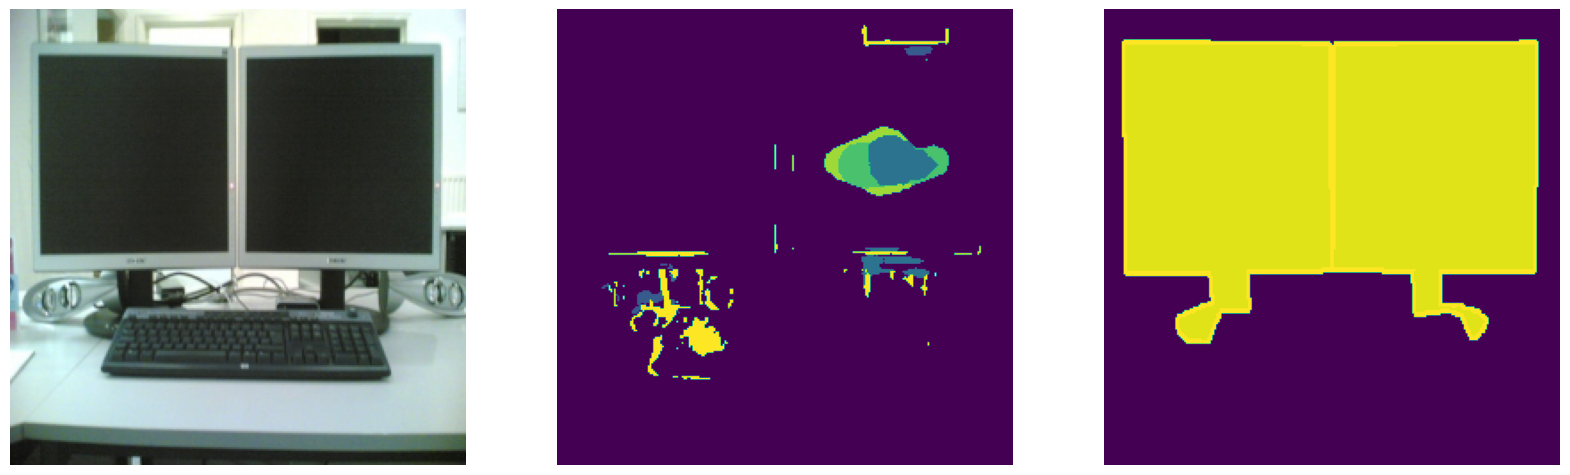

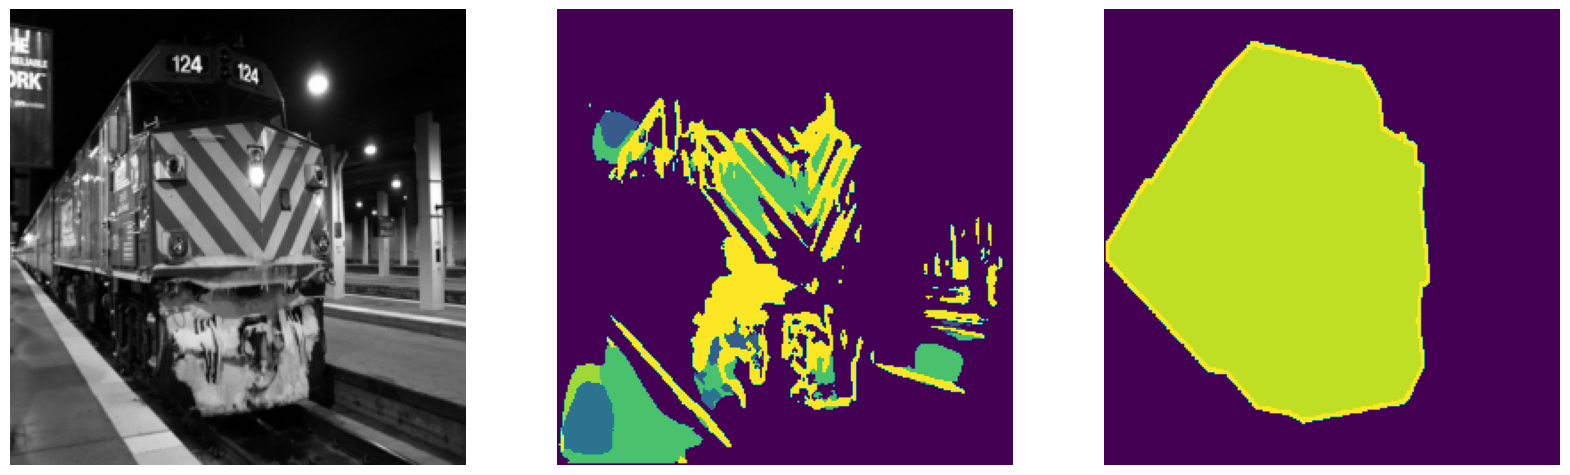

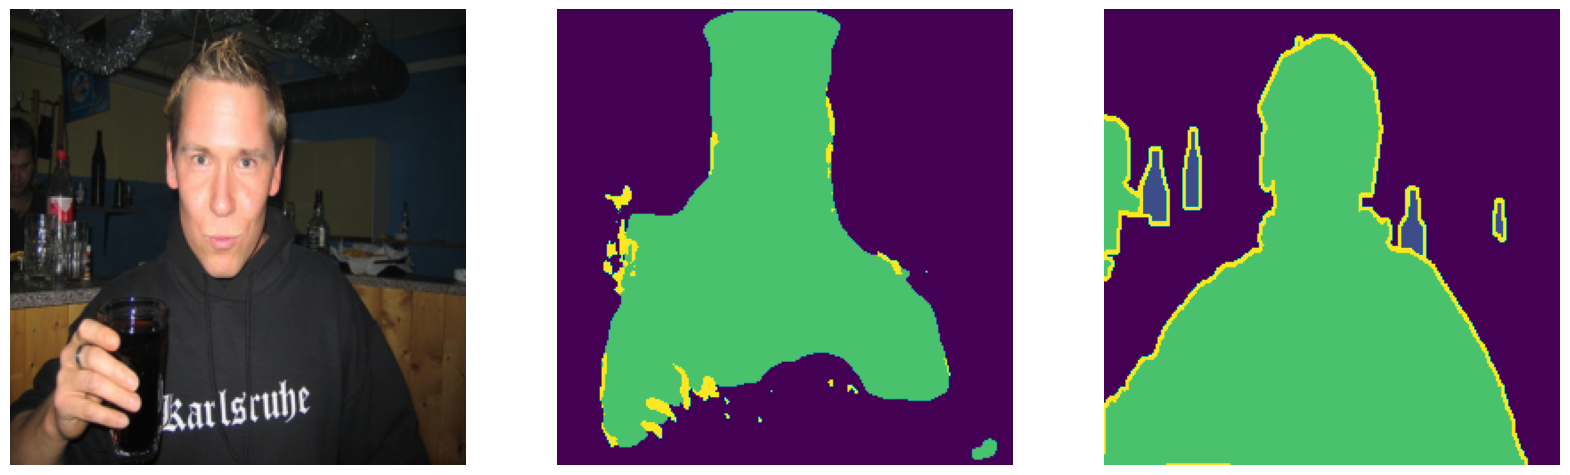

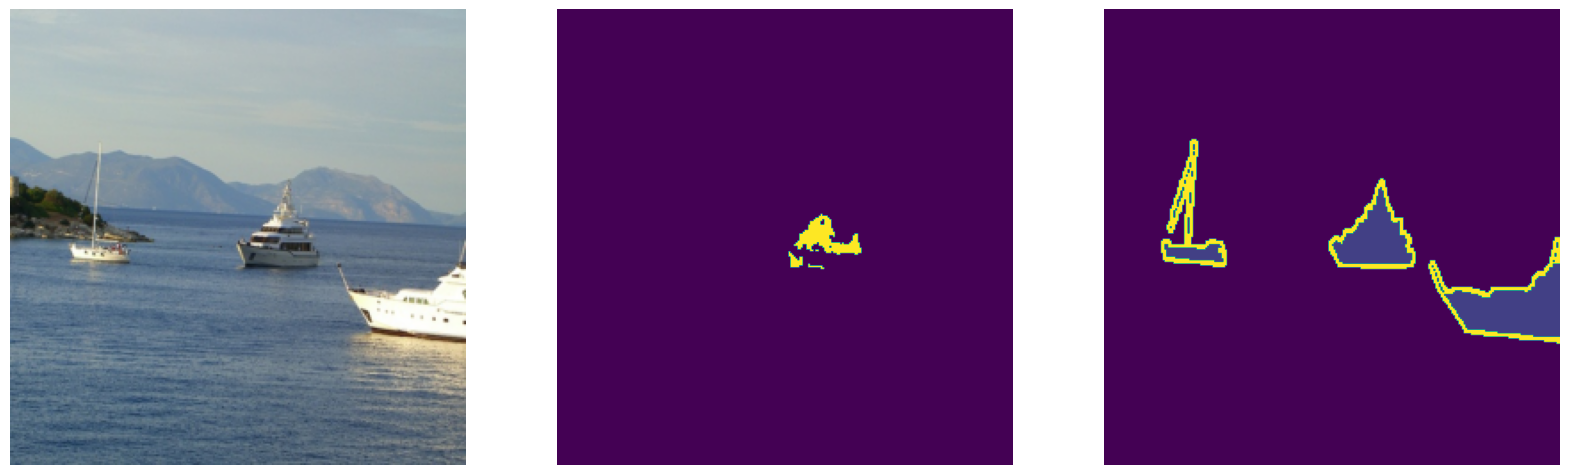

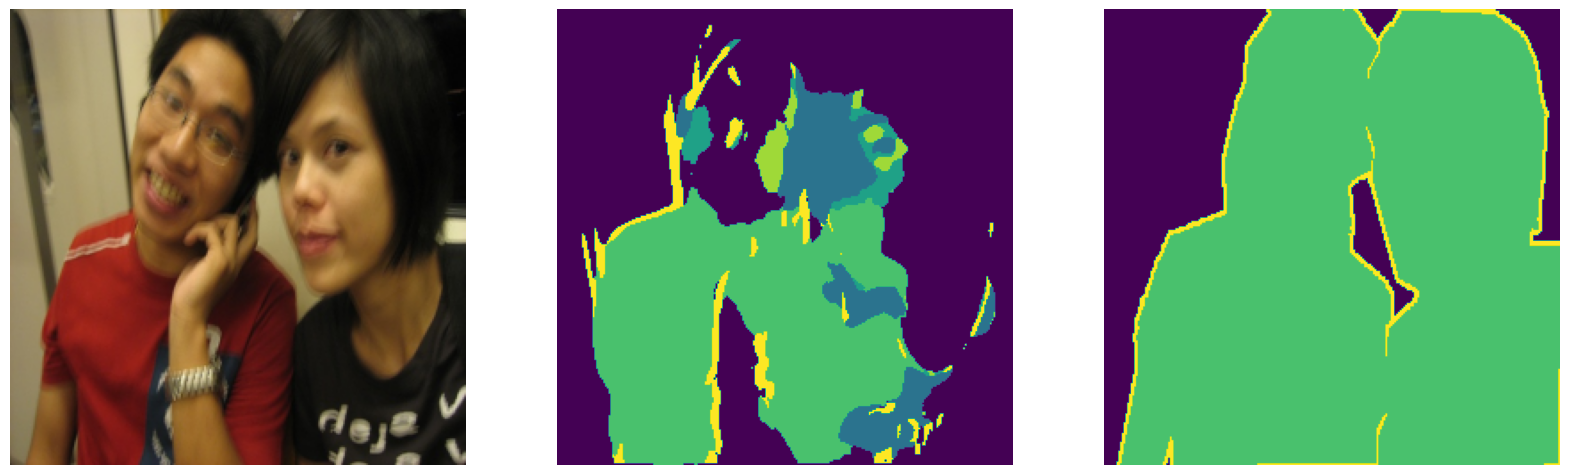

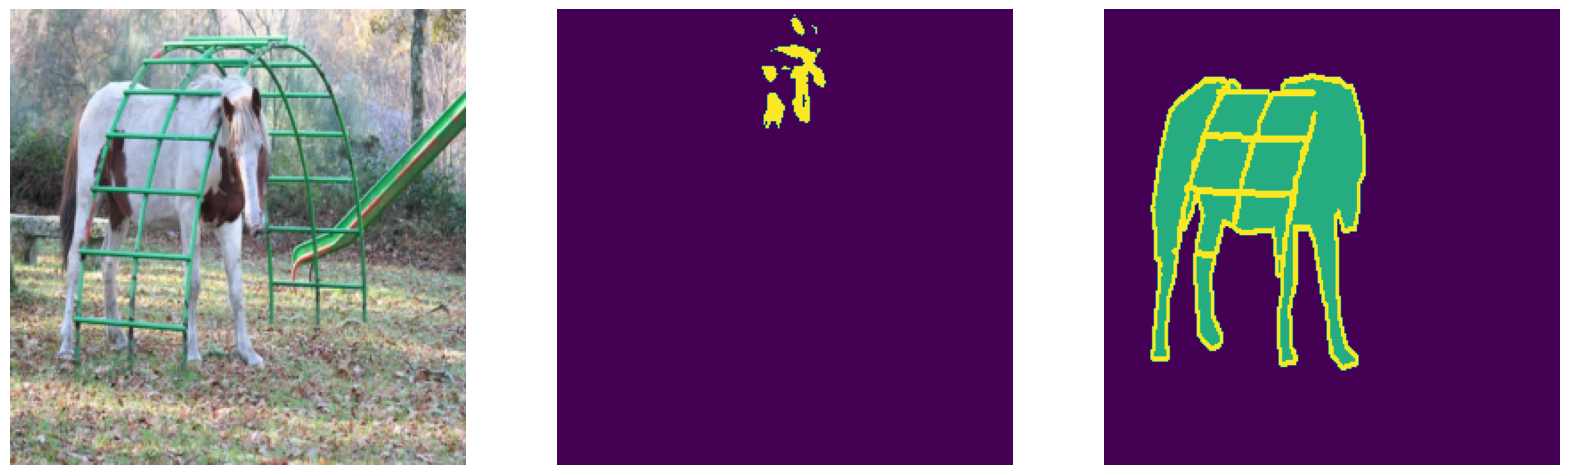

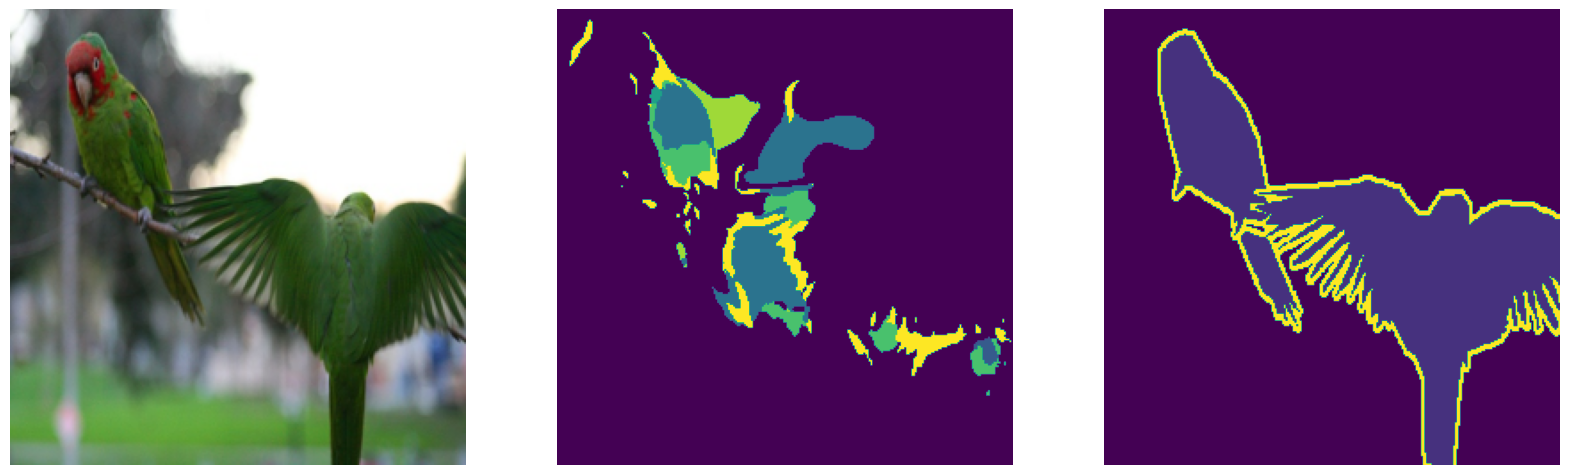

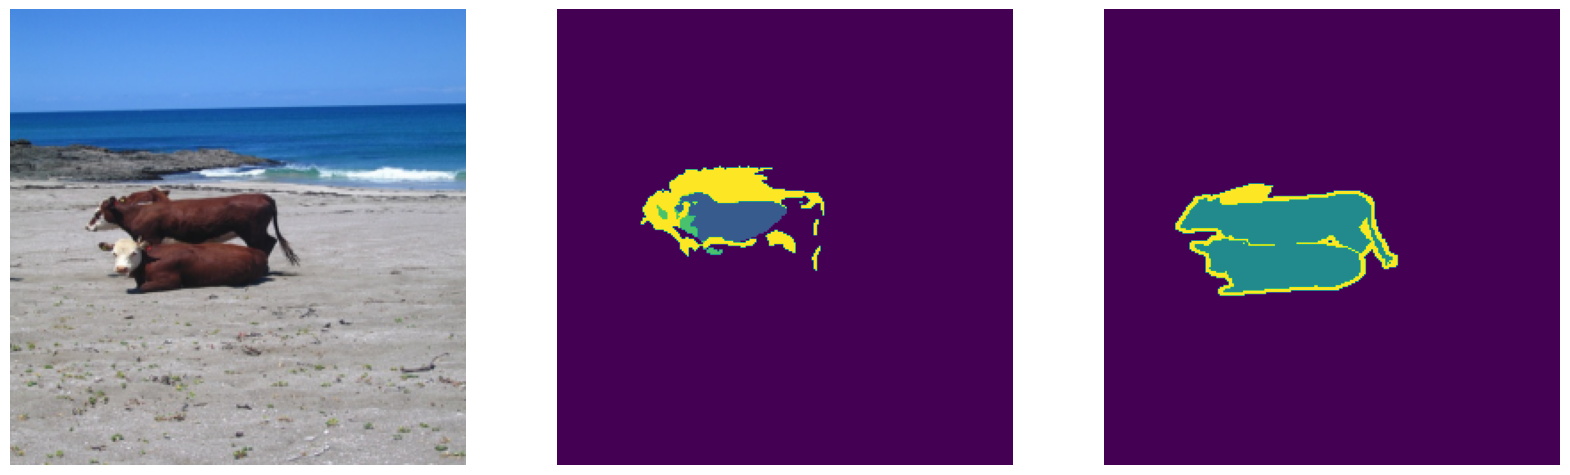

In [15]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')